<a href="https://colab.research.google.com/github/fecampos/examples/blob/main/Ro_copernicus_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip -q install basemap dask xgcm xarray numpy
! pip -q install importlib-metadata==4.13.0
! pip -q install git+https://github.com/pydap/pydap.git
import matplotlib.pyplot as plt
import getpass
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
%matplotlib inline
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import xarray as xr
import numpy as np

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2, threads_per_worker=16)
client = Client(cluster)

     |████████████████████████████████| 864 kB 5.0 MB/s 
     |████████████████████████████████| 60 kB 5.9 MB/s 
     |████████████████████████████████| 6.3 MB 37.8 MB/s 
     |████████████████████████████████| 30.5 MB 1.3 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 114 kB 3.6 MB/s 


In [ ]:
USERNAME = 'fcampos' # aqui hay que cambiar de usuario
DATASET_ID = 'cmems_mod_glo_phy_my_0.083_P1M-m'
PASSWORD = getpass.getpass('Enter your password: ')

In [ ]:
def copernicusmarine_datastore(dataset, username, password):
    from pydap.client import open_url
    from pydap.cas.get_cookies import setup_session
    cas_url = 'https://cmems-cas.cls.fr/cas/login'
    session = setup_session(cas_url, username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
    database = ['my', 'nrt']
    url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{dataset}'
    try:
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits 
    except:
        url = f'https://{database[1]}.cmems-du.eu/thredds/dodsC/{dataset}'
        data_store = xr.backends.PydapDataStore(open_url(url, session=session, user_charset='utf-8')) # needs PyDAP >= v3.3.0 see https://github.com/pydap/pydap/pull/223/commits
    return data_store

In [ ]:
data_store = copernicusmarine_datastore(DATASET_ID, USERNAME, PASSWORD)
ds = xr.open_dataset(data_store)
ds = ds.isel(depth=0)
ds_full = generate_grid_ds(ds, {'Y':'latitude','X':'longitude'})
grid = Grid(ds_full, periodic=['X'])

In [ ]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 329)
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
    depth      float32 0.494
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-05-16T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    sithick    (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    usi        (time, latitude, longitude) float32 ...
    vsi        (time, latitude, longitude) float32 ...
    thetao     (time, latitude, longitude) float32 ...
    so         (time, latitude, longitude) float32 ...
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes: (12/14)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

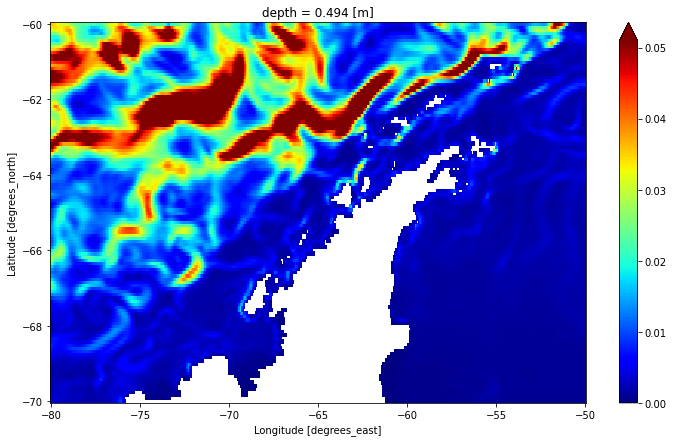

In [ ]:
ds0=ds.sel(time=slice("2000-01-01","2000-03-31"), longitude=slice(-80,-50), latitude= slice(-70,-60))
ke = 0.5*(ds0.uo**2+ds0.vo**2)
(ke.mean(axis=0)).plot(vmin=0, vmax=0.051, cmap="jet", figsize=[12,7])

In [ ]:
dlong = grid.diff(ds_full.longitude, 'X', fill_value=np.nan)
dlonc = grid.diff(ds_full.longitude_left, 'X', fill_value=np.nan)
dlonc_wo_discontinuity = grid.diff(ds_full.longitude_left, 'X', fill_value=np.nan)
dlatg = grid.diff(ds_full.latitude, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.latitude_left, 'Y', boundary='fill', fill_value=np.nan)

In [ ]:
def dll_dist(dlon, dlat, lon, lat):
        distance_1deg_equator = 111000.0
        dx= np.cos(lat*np.pi/180)*dlon*distance_1deg_equator        
        dy = (dlat*(lon * 0) + 1) * distance_1deg_equator
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.longitude, ds_full.latitude)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.longitude, ds_full.latitude)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc

In [ ]:
omega = 7.2921e-5
zeta = grid.interp(grid.diff(ds_full.vo, 'X', boundary="extend")/ds_full.dxg,axis=["X"])\
      -grid.interp(grid.diff(ds_full.uo, 'Y',boundary="fill")/ds_full.dyg, axis=["Y"],boundary="fill")
zeta=zeta/(2*omega*np.sin(np.pi*ds_full.latitude/180))

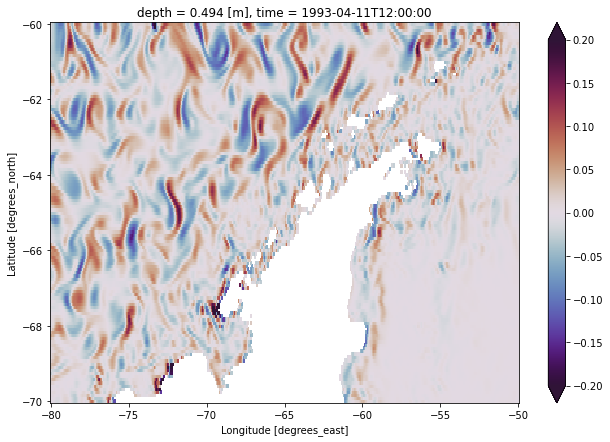

In [ ]:
zeta.sel(longitude=slice(-80,-50), latitude= slice(-70,-60)).plot(vmin=-0.2,
                                                                   vmax=0.2,
                                                                   cmap="twilight_shifted",
                                                                   figsize=[10.5,7])

{155.0: ([<matplotlib.lines.Line2D at 0x7f7ca4965190>],
  [Text(155.025, 24.75, '155°E')]),
 160.0: ([<matplotlib.lines.Line2D at 0x7f7ca4987690>],
  [Text(160.025, 24.75, '160°E')]),
 165.0: ([<matplotlib.lines.Line2D at 0x7f7ca4965110>],
  [Text(165.025, 24.75, '165°E')]),
 170.0: ([<matplotlib.lines.Line2D at 0x7f7ca4965ed0>],
  [Text(170.025, 24.75, '170°E')]),
 175.0: ([<matplotlib.lines.Line2D at 0x7f7ca4987610>],
  [Text(175.025, 24.75, '175°E')]),
 180.0: ([<matplotlib.lines.Line2D at 0x7f7ca4987b90>],
  [Text(179.975, 24.75, '180°')])}

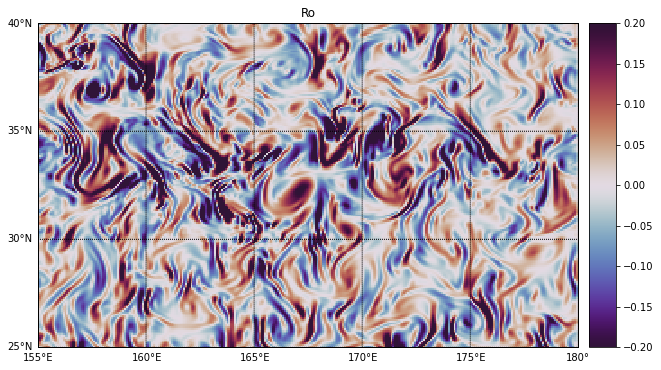

In [ ]:
xx,yy = np.meshgrid(ds.longitude,ds.latitude)

fig = plt.figure(figsize=[8.5, 7], constrained_layout=True)
ax = fig.add_subplot()
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=40,\
            llcrnrlon=155,urcrnrlon=180,resolution='l')
pc = m.pcolor(xx, yy, zeta, vmin=-0.2, vmax=0.2, cmap='twilight_shifted', latlon=True)
plt.title("Ro")
m.drawmapboundary(fill_color='black')
#cb = m.colorbar(pc, location='bottom', label="m$^{2}$s$^{-2}$")
cb = m.colorbar(pc)

parallels = np.arange(0.,90,5)
m.drawparallels(parallels,labels=[True,False,True,False])
meridians = np.arange(10.,351.,5.)
m.drawmeridians(meridians,labels=[True,False,False,True])
#plt.savefig("alpha_"+str(uf[4][39:55])+".png", dpi=200)